In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
from dartsort.localize import localize_torch as loc

path_to_dataset = '/mnt/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/'
path2 = '/mnt/data/noah/IBL_data_CEED/dataset/'

In [4]:
#load recording
pathREC = r'/mnt/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/' #session 2
rec = si.read_binary_folder(pathREC)

In [11]:
geom = np.load(path2 + 'geom_sess2.npy')
templates = np.load(path2 + 'templates_sess2.npy')
spikes_idx = np.load(path2 + 'spike_idx_sess2.npy') #spike time, channel location of max channel, neuron id from spike sorting; for each spike
chans_idx = np.load(path2 + 'chan_idx_sess2.npy')

In [12]:
#dirty fix for going out of range:
if spikes_idx[0][-1] != 0:
    spikes_idx[0][-1]=0
    print('change')

downsampled_spikes = spikes_idx[:,::200]

spikes_idx = downsampled_spikes

change


In [13]:
spikes_idx.shape

(3, 6270)

In [14]:
#get amplitudes vector
amplitudes = rec.get_traces()[spikes_idx[0]] #use spike times as index to grab spikes amplitudes
print(amplitudes.shape) #spikes, channels. max amplitude of each spike on each channel

(6270, 384)


In [15]:
positions = spikes_idx[0]

spike_samples = []
for posit in positions:
    spike_samples.append(list(range(posit-43,posit+78)))
spike_samples = [item for sublist in spike_samples for item in sublist] 

In [158]:
channel_indexs = spikes_idx[1] #need to extend each entry by 121 samples to match shape
channels_extended = []
for chan in channel_indexs:
    channels_extended.append([chan]*121)
channels_extended = [item for sublist in channels_extended for item in sublist]

In [160]:
# channels_extended

In [223]:
# multichan = np.asarray(channels_extended)
# multichan2 = multichan
# for i in range(-5,5+1):
#     if i == 0:
#         continue
#     multichan2 = np.vstack((multichan2, multichan+i))
# # multichan2 = np.delete(multichan2, 0, 0)

In [232]:
multichan = np.empty((11, len(channels_extended)), dtype = 'int')
mainchan = np.asanyarray(channels_extended)
for i, offset in enumerate(range(-5,5+1)):
    multichan[i] = mainchan + offset
    # if i == 0:
    #     continue
    # multichan2 = np.vstack((multichan2, multichan+i))
# multichan2 = np.delete(multichan2, 0, 0)

In [276]:
# for i in range(11):
#     print(multichan2[i])
# print('\n')
# for i in range(11):
#     print(multichan[i])

In [277]:
# print(len(multichan.T))

In [278]:
# multichan2.shape

In [279]:
# help(rec.get_traces)

In [319]:
waveforms = rec.get_traces()[spike_samples, multichan]
# waveforms2 = rec.get_traces()[spike_samples, multichan2]

In [320]:
waveformz = rec.get_traces()[spike_samples, channels_extended]
waveformz.shape


(758670,)

In [321]:
print(waveformz.shape)
new_x = int(waveformz.shape[0]/121)
# # reshape waveform array
waveformz = waveformz.reshape((new_x, 121))
print(waveformz.shape)

(758670,)
(6270, 121)


In [322]:
print(waveforms.shape)
new_x = int(waveforms.shape[1]/121)
# # reshape waveform array
waveforms = waveforms.reshape((11, new_x, 121)) #need to start using einops lol, reshaping is hard
print(waveforms.shape)

(11, 758670)
(11, 6270, 121)


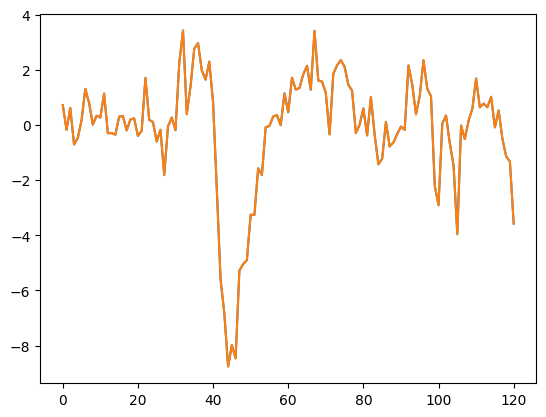

In [323]:
plt.plot(waveformz[0])
plt.plot(waveforms[5,0,:])
plt.show()

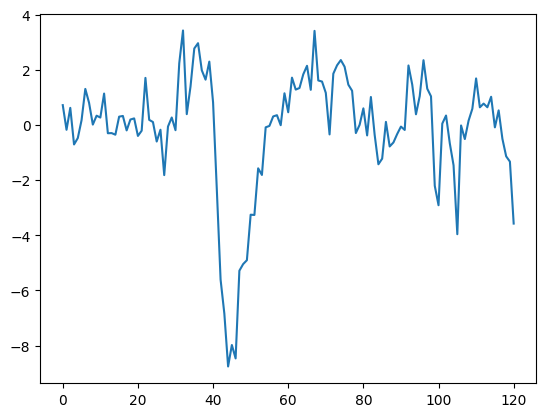

In [328]:
# waveforms are now multichannel!
waveforms = np.swapaxes(waveforms, 0, 1)
plt.plot(waveformss[0,5,:])
plt.show()

In [ ]:
def normalize_wf(wf):
    """Normalize waveform for use in cell type experiments.
    Parameters
    ----------
    wf: numpy.ndarray
        spike that has shape (n_chans, spike_length_samples)
    Returns
    -------
    waveform normalized to the range [0, 1] to retain shape information, but not amplitude information
    """
    if len(wf.shape) == 1:
        _ = wf.shape
        n_chans = None
    else:
        n_chans, _ = wf.shape
    wf = wf.flatten()
    if np.max(np.abs(wf), axis=0) != 0:
        wf /= np.max(np.abs(wf), axis=0)
    wf = wf.reshape(n_chans, -1) if n_chans is not None else wf
    return wf

In [ ]:
radius = 100 #microns #100 correct
num_spikes_st = 0
num_spikes = -1
main_chan = spikes_idx[1]
subset = None
locs = loc.localize_amplitude_vectors(amplitude_vectors = amplitudes[0:num_spikes], n_channels_subset = subset, geom = geom, main_channels = main_chan[0:num_spikes], radius = radius)


In [ ]:
z = locs["z_abs"]
x = locs["x"]
pitch = 40

idx_good = np.flatnonzero(np.logical_and(
    np.logical_and(x > geom[:, 0].min()-pitch, x < geom[:, 0].max()+pitch),
    np.logical_and(z > geom.min()-pitch, z < geom.max()+pitch)))

x = x[idx_good]
z = z[idx_good]
index = spikes_idx[2][idx_good]
waveforms = waveforms[idx_good, :]
amplitudes = amplitudes[idx_good, :]

In [ ]:
import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
# ccolors = cc.glasbey[:31]
ccolors = cc.glasbey[:50]

cols = [get_ccolor(idx) for idx in index]

In [ ]:
plt.figure(figsize=(2,12)) #2,12 is better tbh

plt.scatter(x, z, alpha=0.2, s = 0.5, c = cols) #coloured by neuron id, adds nothing but confirms things work!
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
plt.xlabel('X-position')
plt.ylabel('Z absolute')
#2x12
plt.show()

In [ ]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
waveforms_normalised = np.empty_like(waveforms)
for i, wav in enumerate(waveforms):
    waveforms_normalised[i] = normalize_wf(wav)

In [ ]:
fc_celltype_ckpt_dir = '/home/noah/code/ceed_models/celltype/test'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)